In [17]:
!pip install --quiet gdown


file_id = "1CSkQOyYbQ0aHf67ETLJ58Gp5RlnPkSxZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si.lammps-dump-text

file_id = "1JCFXgqru7S-DCJIZO2Xvar87Tdgfx3qZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si_solid.lammps-dump-text

In [ ]:
!pip install ase matplotlib numpy
from ase.io.lammpsrun import read_lammps_dump
from ase.neighborlist import neighbor_list
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# --------- File paths for liquid and solid MD trajectories ---------
file_liquid = "si.lammps-dump-text"
file_solid  = "si_solid.lammps-dump-text"

# --------- RDF settings ---------
rdf_cutoff = 10.0  # cutoff radius in Ångströms (1 nm)
rdf_bins = 200     # number of bins for RDF histogram
bin_width = rdf_cutoff / rdf_bins

# --------- Read the last 10 frames to represent the equilibrium state ---------
frames_liquid = read_lammps_dump(file_liquid, index=slice(-10, None))
frames_solid  = read_lammps_dump(file_solid, index=slice(-10, None))

In [19]:
def compute_rdf_single_frame(atoms, r_max=10.0, bin_width=0.05):
    """
    Compute RDF for a single frame.
    """
    positions = atoms.get_positions()
    cell = atoms.get_cell()
    volume = atoms.get_volume()
    N = len(atoms)

    i, j, d = neighbor_list('ijd', atoms, cutoff=r_max)
    mask = j > i
    d = d[mask]

    bins = np.arange(0, r_max + bin_width, bin_width)
    hist, edges = np.histogram(d, bins=bins)
    r = 0.5 * (edges[1:] + edges[:-1])
    shell_vol = 4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3)
    rho = N / volume
    g_r = hist / (shell_vol * rho * N)
    return g_r

In [23]:
# --------- Compute RDFs for both trajectories ---------
# 计算所有帧的RDF并平均
rdf_liquid_accum = np.zeros(rdf_bins)
rdf_solid_accum = np.zeros(rdf_bins)

for frame in frames_liquid:
    rdf_liquid_accum += compute_rdf_single_frame(frame, r_max=rdf_cutoff, bin_width=bin_width)

for frame in frames_solid:
    rdf_solid_accum += compute_rdf_single_frame(frame, r_max=rdf_cutoff, bin_width=bin_width)

rdf_liquid = rdf_liquid_accum / len(frames_liquid)
rdf_solid = rdf_solid_accum / len(frames_solid)

r = np.linspace(bin_width/2, rdf_cutoff-bin_width/2, rdf_bins)

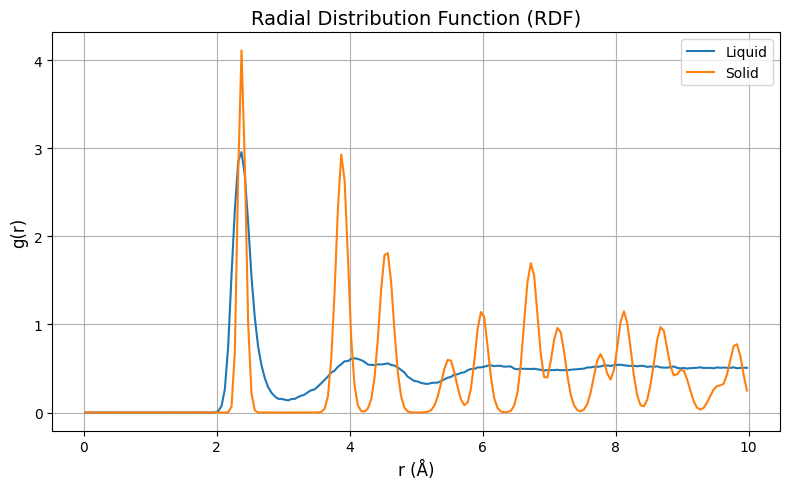

In [26]:
# --------- Plotting RDFs ---------
plt.figure(figsize=(8, 5))
plt.plot(r, rdf_liquid, label='Liquid')
plt.plot(r, rdf_solid, label='Solid')
plt.xlabel('r (Å)', fontsize=12)
plt.ylabel('g(r)', fontsize=12)
plt.title('Radial Distribution Function (RDF)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("rdf_comparison.png")  # Save as image file
plt.show()